## Deep MNIST Tensorflow Tutorial

Source: https://www.tensorflow.org/get_started/mnist/pros

In this tutorial:
- Create a softmax regression function that is a model for recognizing MNIST digits, based on looking at every pixel in the image
- Use Tensorflow to train the model to recognize digits by having it "look" at thousands of examples (and run our first Tensorflow session to do so)
- Check the model's accuracy with our test data
- Build, train, and test a multilayer convolutional neural network to improve the results

### Setup

Loading MNIST Data

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/Users/christopherlabiak/Desktop/MNIST_data', one_hot=True)

Extracting /Users/christopherlabiak/Desktop/MNIST_data/train-images-idx3-ubyte.gz
Extracting /Users/christopherlabiak/Desktop/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /Users/christopherlabiak/Desktop/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /Users/christopherlabiak/Desktop/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(mnist.train.labels)))
print("- Test-set:\t\t{}".format(len(mnist.test.labels)))
#Do not use the validation set here
print("- Validation-set:\t{}".format(len(mnist.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


### Start TensorFlow InteractiveSession 

- TF relies on a C++ backend for computation
- Create a connection through a session

In [3]:
import tensorflow as tf
sess = tf.InteractiveSession()

### Build a Softmax Regression Model

#### Placeholders

In [4]:
#Placeholder
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

#### Variables

Before Variables can be used within a session, they must be initialized using that session. 

In [5]:
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# Initialize all variables at once
sess.run(tf.global_variables_initializer())

#### Predicting Class and Loss Function 

We can now implement the regression model

In [6]:
y = tf.matmul(x,W) + b

And specify the loss function. Loss indicates how bad the model's prediction was on a single example. Here, the loss function is the cross-entropy between the target and the softmax activation function applied to the model's prediction

In [7]:
#Note that tf.nn.softmax_cross_entropy_with_logits internally applies 
#the softmax on the model's unnormalized model prediction and sums across all classes, 
#and tf.reduce_mean takes the average over these sums.
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

### Train the Model

Since we have defined the model and loss function, tensorflow knows the entire computation graph and it can use automatic differentation to find the gradients of the loss with respect to each of the variables

In [8]:
# Optimization algo: Steepest gradient descent with a step length of 0.5
# This line adds new operations to the computation graph. 
# These operations included ones to compute gradients, compute parameter
# update steps, and apply update steps to the parameters
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

Train_step will apply the gradient descent updates to the parameters. Training the model can therefore be accomplished by repeatedly running train_step. We load 100 training examples in each training iteration. The feed dict replaces the placeholder tensors x and y with training examples

In [9]:
for _ in range(1):
    batch = mnist.train.next_batch(1)
    print
    #train_step.run(feed_dict = {x: batch[0], y_: batch[1]})

In [10]:
#for _ in range(1):
#    batch_validate = mnist.train.next_batch(1)
#    print(batch_validate)
    #validate_step.run(feed_dict = {xv: batch_validate[0], yv_: batch_validate[1]})

### Evaluate the Model

In [11]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.098


## Build a Multilayer Convolution Network

### Weight Initialization

Need to create a lot of weights and biases. Good practice to initialize them with a slightly positive initial bias to avoid "dead neurons"

In [12]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### Convolution and Pooling 

TF provides lots of flexibility with regards to convolution and pooling, but we will stick to the vanilla version for this tutorial. Convolutions will use a stride of one and are zero padded so that the output is the same as the input. Our pooling is plain old max pooling over 2x2 blocks.

In [13]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#### First Convolution Layer

The first layer will consist of convolution, followed by max pooling. The convolution will compute 32 features for each 5x5 patch. Its weight tensore will have a shape of [5, 5, 1, 32], where [patch_dimension, patch_dimension, input_channels, output_channels]. Plus, an additional bias vector with a component for each output channel.

In [14]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

First reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.

In [15]:
x_image = tf.reshape(x, [-1,28,28,1])

Next, convolve x_image with the weight tensor, add the bias, and apply the ReLU function, and finally max pool. The max pool method will reduce the image size to 14x14.

In [16]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#### Second Convolution Layer

In order for a deep network, we stack several layers of this type. This second layer will have 64 features for each 5x5 patch.

In [17]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#### Densely Connected Layer

The image size is reduced to 7x7. We now add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [18]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

#### Dropout

To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during the dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.

In [19]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#### Readout Layer

Finally, we add a layer, just like for the one layer softmax regression above.

In [20]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [21]:
#tf.argmax(y_conv,1)

<tf.Tensor 'ArgMax_2:0' shape=(?,) dtype=int64>

### Train and Evaluate the Model

To train and evaluate it we will use code that is nearly identical to that for the simple one layer SoftMax network above.

Differences:
- We will replace the steepest gradient descent optimizer with the more sophisticated ADAM optimizer.
- We will include the additional parameter keep_prob in feed_dict to control the dropout rate.
- We will add logging to every 100th iteration in the training process.

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.axis([0, 500, 0, 1])

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
x_list = []
validation_y = []
training_y = []

batch_size = 100
n_epochs = 10

#for epoch_i in range(n_epochs):
#    x_list.append(epoch_i)
#    print("epoch %d, validation accuracy %g"%(epoch_i, validation_accuracy))
for i in range(5000):

    #validation_batch = mnist.validation.next_batch(50)
    batch = mnist.train.next_batch(batch_size)
    if i%20 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        validation_accuracy = accuracy.eval(feed_dict={
            x: mnist.validation.images, y_: mnist.validation.labels, keep_prob: 1.0})
        validation_y.append(validation_accuracy)
        x_list.append(i)
        training_y.append(train_accuracy)
    if i%100 == 0:
        print("step %d, validation accuracy %g, train accuracy %g"%(i, validation_accuracy, train_accuracy))
    #train_step.run(feed_dict={x: validation_batch[0], y_: validation_batch[1], keep_prob: 0.5})
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    
#plt.show()

step 0, validation accuracy 0.1132, train accuracy 0.09
step 100, validation accuracy 0.8864, train accuracy 0.87
step 200, validation accuracy 0.9278, train accuracy 0.92
step 300, validation accuracy 0.9434, train accuracy 0.88
step 400, validation accuracy 0.9502, train accuracy 0.97
step 500, validation accuracy 0.958, train accuracy 0.9
step 600, validation accuracy 0.9584, train accuracy 0.92
step 700, validation accuracy 0.9686, train accuracy 0.91
step 800, validation accuracy 0.9702, train accuracy 0.95
step 900, validation accuracy 0.9716, train accuracy 0.99
step 1000, validation accuracy 0.974, train accuracy 0.98
step 1100, validation accuracy 0.9742, train accuracy 0.96
step 1200, validation accuracy 0.977, train accuracy 0.98
step 1300, validation accuracy 0.9776, train accuracy 0.97
step 1400, validation accuracy 0.979, train accuracy 0.98
step 1500, validation accuracy 0.98, train accuracy 1
step 1600, validation accuracy 0.98, train accuracy 0.99
step 1700, validation

The final test set accuracy after running this code should be approximately 99.2%.

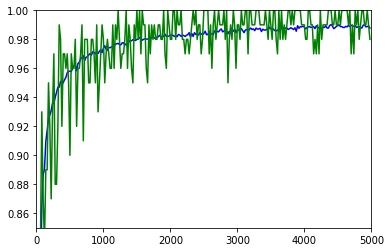

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.axis([0, 5000, 0.85, 1])
plt.plot(x_list, validation_y, 'b', x_list, training_y, 'g')